### 介绍

这一节以Scaffold算法为例子，介绍如何实现一个在联邦各阶段都有所修改的算法。该算法由Karimireddy等人于2019年提出（[论文链接](https://arxiv.org/abs/1910.06378)），并发表于ICML 2020。

Scaffold主要解决的问题是：联邦学习中数据non-iid分布使用户多轮本地训练容易越走越偏，最终降低模型精度和减慢收敛速度。为了缓解该问题，作者提出了一种在本地训练阶段不断修正模型更新方向的策略，即每一步更新都添加一个修补项，来防止更新方向走偏。文中示意图如下：
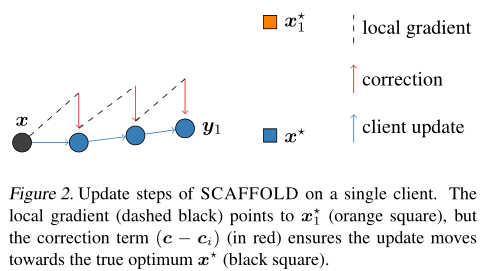

下面介绍算法的主要流程。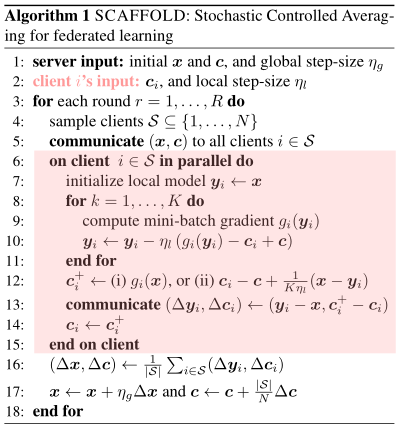

上图为它论文中的算法伪代码。相较于fedavg，它在本地训练阶段、通信阶段、聚合阶段做了以下修改：
* **本地训练阶段**：
    I. 每一步模型的更新从$\mathbf y_i\leftarrow \mathbf y_i-\eta g_i(\mathbf y_i) $变为了$\mathbf y_i\leftarrow \mathbf y_i-\eta (g_i(\mathbf y_i)-\mathbf c_i +\mathbf c) $；
    II. 更新本地控制变量$\mathbf c_i$ (control variates)；
* **通信阶段**：服务器打包发送全局模型和控制变量$(\mathbf x,\mathbf c)$给用户；用户返回$(\Delta\mathbf y_i, \Delta\mathbf c_i)$给服务器；
* **聚合阶段**：服务器不直接聚合全局模型，而是分别聚合所有人的本地模型和本地控制变量的更新量为 

    $$(\Delta\mathbf x, \Delta\mathbf c)\leftarrow\frac{1}{|\mathcal{S}|}\sum_{i\in \mathcal{S}}(\Delta\mathbf y_i, \Delta\mathbf c_i)$$

    然后更新全局模型和全局控制变量为：

    $$\mathbf x\leftarrow \mathbf x+\eta_g\Delta\mathbf x\text{ and }\mathbf c\leftarrow \mathbf c+\frac{|\mathcal{S}|}{N}\Delta\mathbf c$$

## 实现Scaffold

按照上述总结的步骤，依次修改代码中相对应的部分。由于服务器、用户接收到的东西变了，因此需要额外调整Server.iterate方法和Client.reply方法。最后，在原文中Scaffold的采样方式仅支持对用户不放回均匀采样，因此在初始化方法中设置该项。Scaffold完整代码如下：

In [3]:
from flgo.algorithm.fedbase import BasicServer, BasicClient
import copy
from flgo.utils import fmodule
import torch

class Server(BasicServer):
    def initialize(self, *args, **kwargs):
        self.init_algo_para({'eta': 1.0})
        self.cg = self.model.zeros_like()
        self.sample_option = 'uniform'

    def pack(self, client_id, *args, **kwargs):
        return {
            "model": copy.deepcopy(self.model),
            "cg": self.cg,
        }

    def iterate(self):
        # sample clients
        self.selected_clients = self.sample()
        # local training
        res = self.communicate(self.selected_clients)
        dys, dcs = res['dy'], res['dc']
        # aggregate
        self.model, self.cg = self.aggregate(dys, dcs)
        return

    def aggregate(self, dys, dcs):
        # x <-- x + eta_g * dx = x + eta_g * average(dys)
        # c <-- c + |S|/N * dc = c + 1/N * sum(dcs)
        new_model = self.model + self.eta * fmodule._model_average(dys)
        new_c = self.cg + fmodule._model_sum(dcs)/self.num_clients
        return new_model, new_c


class Client(BasicClient):
    def initialize(self, *args, **kwargs):
        self.c = None

    @fmodule.with_multi_gpus
    def train(self, model, cg):
        """
        The codes of Algorithm 1 that updates the control variate
          12:  ci+ <-- ci - c + 1 / K / eta_l * (x - yi)
          13:  communicate (dy, dc) <-- (yi - x, ci+ - ci)
          14:  ci <-- ci+
        Our implementation for efficiency
          dy = yi - x
          dc <-- ci+ - ci = -1/K/eta_l * (yi - x) - c = -1 / K /eta_l *dy - c
          ci <-- ci+ = ci + dc
          communicate (dy, dc)
        """
        model.train()
        # global parameters
        src_model = copy.deepcopy(model)
        src_model.freeze_grad()
        cg.freeze_grad()
        # if self.c is None: self.c = copy.deepcopy(cg)
        if self.c is None: self.c = cg.zeros_like()
        self.c.freeze_grad()
        optimizer = self.calculator.get_optimizer(model, lr=self.learning_rate, weight_decay=self.weight_decay,
                                                  momentum=self.momentum)
        for iter in range(self.num_steps):
            batch_data = self.get_batch_data()
            model.zero_grad()
            loss = self.calculator.compute_loss(model, batch_data)['loss']
            loss.backward()
            # y_i <-- y_i - eta_l ( g_i(y_i)-c_i+c )  =>  g_i(y_i)' <-- g_i(y_i)-c_i+c
            for pm, pcg, pc in zip(model.parameters(), cg.parameters(), self.c.parameters()):
                pm.grad = pm.grad - pc + pcg
            optimizer.step()
        dy = model - src_model
        dc = -dy/(self.num_steps * self.learning_rate) - cg
        self.c = self.c + dc
        return dy, dc

    def pack(self, dy, dc):
        return {
            "dy": dy,
            "dc": dc,
        }

    def unpack(self, received_pkg):
        # unpack the received package
        return received_pkg['model'], received_pkg['cg']

    def reply(self, svr_pkg):
        model, c_g = self.unpack(svr_pkg)
        dy, dc = self.train(model, c_g)
        cpkg = self.pack(dy, dc)
        return cpkg

class scaffold:
    Server=Server
    Client=Client

## 测试Scaffold

为了测试Scaffold的性能，这里适用MNIST的一种较为极端的划分，一人仅持有1类的数据，一共30人，来检验性能。代码如下：

In [1]:
import flgo
import os
task = './cifar_label2'
config = {'benchmark':{'name':'flgo.benchmark.cifar10_classification'},'partitioner':{'name': 'DiversityPartitioner','para':{'num_clients':10,'diversity':0.2}}}
if not os.path.exists(task): flgo.gen_task(config, task_path = task)

In [4]:
import flgo.algorithm.fedavg as fedavg
option = {'gpu':[1,],'log_file':True, 'num_rounds':50, 'proportion':1.0, 'learning_rate':0.01, 'num_epochs':10, 'sample':'uniform'}
fedavg_runner = flgo.init(task, fedavg, option=option)
fedavg_runner.run()
scaffold_runner = flgo.init(task, scaffold, option=option)
scaffold_runner.run()

2023-03-14 22:39:21,886 fflow.py init [line:347] INFO Initializing devices: cuda:1 will be used for this running.


Files already downloaded and verified
Files already downloaded and verified


2023-03-14 22:39:25,267 fflow.py init [line:389] INFO Use `<class 'flgo.system_simulator.default_simulator.Simulator'>` as the system simulator
2023-03-14 22:39:25,267 fflow.py init [line:397] INFO Ready to start.
2023-03-14 22:39:25,268 fedbase.py run [line:104] INFO --------------Initial Evaluation--------------
2023-03-14 22:39:25,268 simple_logger.py log_once [line:13] INFO Current_time:0
2023-03-14 22:39:28,536 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1005
2023-03-14 22:39:28,536 simple_logger.py log_once [line:27] INFO test_loss                     2.3033
2023-03-14 22:39:28,537 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1028
2023-03-14 22:39:28,537 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1028
2023-03-14 22:39:28,537 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1721
2023-03-14 22:39:28,538 simple_logger.py log_once [line:27] INFO valid_loss                   

2023-03-14 22:50:10,715 fedbase.py run [line:121] INFO Eval Time Cost:               2.6474s
2023-03-14 22:51:54,398 fedbase.py run [line:113] INFO Iterate Time Cost:            103.6821s
2023-03-14 22:51:54,399 fedbase.py run [line:116] INFO --------------Round 7--------------
2023-03-14 22:51:54,399 simple_logger.py log_once [line:13] INFO Current_time:7
2023-03-14 22:51:56,976 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4755
2023-03-14 22:51:56,977 simple_logger.py log_once [line:27] INFO test_loss                     1.4696
2023-03-14 22:51:56,977 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4612
2023-03-14 22:51:56,978 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4612
2023-03-14 22:51:56,978 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1312
2023-03-14 22:51:56,978 simple_logger.py log_once [line:27] INFO valid_loss                    1.4972
2023-03-14 22:51:56,978 simpl

2023-03-14 23:02:51,756 fedbase.py run [line:121] INFO Eval Time Cost:               2.5662s
2023-03-14 23:04:26,820 fedbase.py run [line:113] INFO Iterate Time Cost:            95.0629s
2023-03-14 23:04:26,820 fedbase.py run [line:116] INFO --------------Round 14--------------
2023-03-14 23:04:26,821 simple_logger.py log_once [line:13] INFO Current_time:14
2023-03-14 23:04:29,485 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5184
2023-03-14 23:04:29,486 simple_logger.py log_once [line:27] INFO test_loss                     1.3968
2023-03-14 23:04:29,486 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5110
2023-03-14 23:04:29,486 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5110
2023-03-14 23:04:29,487 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1939
2023-03-14 23:04:29,487 simple_logger.py log_once [line:27] INFO valid_loss                    1.4214
2023-03-14 23:04:29,487 simp

2023-03-14 23:14:14,299 fedbase.py run [line:121] INFO Eval Time Cost:               2.5859s
2023-03-14 23:15:47,763 fedbase.py run [line:113] INFO Iterate Time Cost:            93.4635s
2023-03-14 23:15:47,763 fedbase.py run [line:116] INFO --------------Round 21--------------
2023-03-14 23:15:47,764 simple_logger.py log_once [line:13] INFO Current_time:21
2023-03-14 23:15:50,335 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5297
2023-03-14 23:15:50,335 simple_logger.py log_once [line:27] INFO test_loss                     1.3986
2023-03-14 23:15:50,336 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5232
2023-03-14 23:15:50,336 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5232
2023-03-14 23:15:50,336 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2135
2023-03-14 23:15:50,337 simple_logger.py log_once [line:27] INFO valid_loss                    1.4244
2023-03-14 23:15:50,337 simp

2023-03-14 23:25:32,568 fedbase.py run [line:121] INFO Eval Time Cost:               2.5597s
2023-03-14 23:27:05,981 fedbase.py run [line:113] INFO Iterate Time Cost:            93.4126s
2023-03-14 23:27:05,982 fedbase.py run [line:116] INFO --------------Round 28--------------
2023-03-14 23:27:05,983 simple_logger.py log_once [line:13] INFO Current_time:28
2023-03-14 23:27:08,537 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5624
2023-03-14 23:27:08,538 simple_logger.py log_once [line:27] INFO test_loss                     1.3198
2023-03-14 23:27:08,538 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5630
2023-03-14 23:27:08,539 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5630
2023-03-14 23:27:08,539 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1240
2023-03-14 23:27:08,539 simple_logger.py log_once [line:27] INFO valid_loss                    1.3528
2023-03-14 23:27:08,540 simp

2023-03-14 23:36:53,681 fedbase.py run [line:121] INFO Eval Time Cost:               2.7108s
2023-03-14 23:38:29,522 fedbase.py run [line:113] INFO Iterate Time Cost:            95.8406s
2023-03-14 23:38:29,523 fedbase.py run [line:116] INFO --------------Round 35--------------
2023-03-14 23:38:29,524 simple_logger.py log_once [line:13] INFO Current_time:35
2023-03-14 23:38:32,105 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5560
2023-03-14 23:38:32,106 simple_logger.py log_once [line:27] INFO test_loss                     1.3747
2023-03-14 23:38:32,106 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5518
2023-03-14 23:38:32,107 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5518
2023-03-14 23:38:32,107 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1316
2023-03-14 23:38:32,108 simple_logger.py log_once [line:27] INFO valid_loss                    1.4124
2023-03-14 23:38:32,108 simp

2023-03-14 23:48:09,971 fedbase.py run [line:121] INFO Eval Time Cost:               2.6383s
2023-03-14 23:49:44,891 fedbase.py run [line:113] INFO Iterate Time Cost:            94.9203s
2023-03-14 23:49:44,892 fedbase.py run [line:116] INFO --------------Round 42--------------
2023-03-14 23:49:44,892 simple_logger.py log_once [line:13] INFO Current_time:42
2023-03-14 23:49:47,522 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5479
2023-03-14 23:49:47,522 simple_logger.py log_once [line:27] INFO test_loss                     1.5051
2023-03-14 23:49:47,523 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5442
2023-03-14 23:49:47,523 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5442
2023-03-14 23:49:47,524 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1629
2023-03-14 23:49:47,524 simple_logger.py log_once [line:27] INFO valid_loss                    1.5415
2023-03-14 23:49:47,524 simp

2023-03-14 23:59:33,488 fedbase.py run [line:121] INFO Eval Time Cost:               2.6286s
2023-03-15 00:01:07,283 fedbase.py run [line:113] INFO Iterate Time Cost:            93.7945s
2023-03-15 00:01:07,284 fedbase.py run [line:116] INFO --------------Round 49--------------
2023-03-15 00:01:07,284 simple_logger.py log_once [line:13] INFO Current_time:49
2023-03-15 00:01:09,874 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5384
2023-03-15 00:01:09,874 simple_logger.py log_once [line:27] INFO test_loss                     1.6187
2023-03-15 00:01:09,875 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5318
2023-03-15 00:01:09,875 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5318
2023-03-15 00:01:09,875 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1772
2023-03-15 00:01:09,876 simple_logger.py log_once [line:27] INFO valid_loss                    1.6864
2023-03-15 00:01:09,876 simp

## 与fedavg性能比较

这里在CIFAR10-10个用户，一人持有两类标签的场景下进行对比，超参数设置使用[NIID-Bench](https://github.com/Xtra-Computing/NIID-Bench)中相同数据划分场景的设置：通信轮数num_rounds=50，本地更新轮数num_epochs=10，步长learning_rate=0.01,批大小batch_size=64, 进行全采样proportion=1.0。得到的结果使用下面代码可视化：

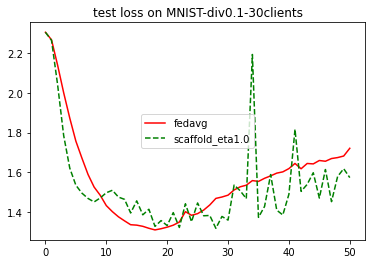

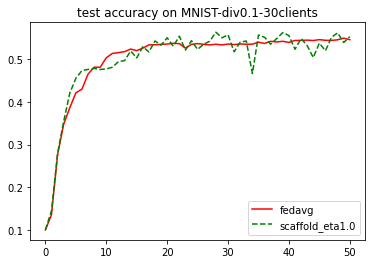

In [12]:
import flgo.experiment.analyzer
analysis_plan = {
    'Selector':{
        'task': task,
        'header':['fedavg','scaffold' ],
    },
    'Painter':{
        'Curve':[
            {'args':{'x': 'communication_round', 'y':'test_loss'}, 'obj_option':{'ls':['-','--'], 'c':['r','g']}, 'fig_option':{'title':'test loss on MNIST-div0.1-30clients'}},
            {'args':{'x': 'communication_round', 'y':'test_accuracy'},  'obj_option':{'ls':['-','--'], 'c':['r','g']}, 'fig_option':{'title':'test accuracy on MNIST-div0.1-30clients'}},
        ]
    }
}
flgo.experiment.analyzer.show(analysis_plan)

可以看到scaffold前期收敛略快于fedavg，而收敛的精度与fedavg相近。且由于scaffold振荡更大，获得的最大测试集精度高于fedavg。